# Imports

In [2]:
!pip install -q scikit-learn==1.2.2
!pip install -q kagglehub --upgrade

In [3]:
import kagglehub
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings
import time
import random


from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.model_selection import learning_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from xgboost import XGBClassifier

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Lung Cancer Dataset
This dataset available at https://www.kaggle.com/datasets/thedevastator/cancer-patients-and-air-pollution-a-new-link, it contains information on patients and factors related to lung cancer risk. It includes 26 features on a 1–10 scale, with higher values generally indicating greater severity.

**Key Features:**
* Demographics:
Age (years), Gender (encoded numerically).

* Environmental and Lifestyle Factors:
Air Pollution, Alcohol use, Dust Allergy, Occupational Hazards.

* Genetic and Health History:
Genetic Risk, Chronic Lung Disease.
* Symptoms:
Includes Fatigue, Weight Loss, Shortness of Breath, Dry Cough, etc.

* Outcome:
Level: Severity of lung cancer risk (Low, Medium, High).

# Exploratory Data Analysis
Load the dataset from Kaggle using kagglehub, and perform initial exploratory data analysis (EDA) to understand the structure and basic statistics of the data.

In [4]:
# Load data
path = kagglehub.dataset_download("thedevastator/cancer-patients-and-air-pollution-a-new-link")
file_name = "cancer patient data sets.csv"
file_path = os.path.join(path, file_name)
df=pd.read_csv(file_path)
df.head()

100%|██████████| 7.36k/7.36k [00:00<00:00, 12.0MB/s]

Extracting files...


,index,Patient Id,Age,Gender,Air Pollution,Alcohol use,Dust Allergy,OccuPational Hazards,Genetic Risk,chronic Lung Disease,...,Fatigue,Weight Loss,Shortness of Breath,Wheezing,Swallowing Difficulty,Clubbing of Finger Nails,Frequent Cold,Dry Cough,Snoring,Level
0,0,P1,33,1,2,4,5,4,3,2,...,3,4,2,2,3,1,2,3,4,Low
1,1,P10,17,1,3,1,5,3,4,2,...,1,3,7,8,6,2,1,7,2,Medium
2,2,P100,35,1,4,5,6,5,5,4,...,8,7,9,2,1,4,6,7,2,High
3,3,P1000,37,1,7,7,7,7,6,7,...,4,2,3,1,4,5,6,7,5,High
4,4,P101,46,1,6,8,7,7,7,6,...,3,2,4,1,4,2,4,2,3,High


In [5]:
print("EDA: Basic Information\n")
print("DataFrame Info:")
print(df.info())

print("\nDescribe Numeric Columns:")
display(df.describe())

# Let's create lists of numeric and categorical columns
numerical_cols = df.select_dtypes(include=[np.number]).columns
categorical_cols = df.select_dtypes(exclude=[np.number]).columns

EDA: Basic Information

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   index                     1000 non-null   int64 
 1   Patient Id                1000 non-null   object
 2   Age                       1000 non-null   int64 
 3   Gender                    1000 non-null   int64 
 4   Air Pollution             1000 non-null   int64 
 5   Alcohol use               1000 non-null   int64 
 6   Dust Allergy              1000 non-null   int64 
 7   OccuPational Hazards      1000 non-null   int64 
 8   Genetic Risk              1000 non-null   int64 
 9   chronic Lung Disease      1000 non-null   int64 
 10  Balanced Diet             1000 non-null   int64 
 11  Obesity                   1000 non-null   int64 
 12  Smoking                   1000 non-null   int64 
 13  Passive Smoker            1000 non-null

,index,Age,Gender,Air Pollution,Alcohol use,Dust Allergy,OccuPational Hazards,Genetic Risk,chronic Lung Disease,Balanced Diet,...,Coughing of Blood,Fatigue,Weight Loss,Shortness of Breath,Wheezing,Swallowing Difficulty,Clubbing of Finger Nails,Frequent Cold,Dry Cough,Snoring
count,1000.000000,1000.000000,1000.000000,1000.0000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,499.500000,37.174000,1.402000,3.8400,4.563000,5.165000,4.840000,4.580000,4.380000,4.491000,...,4.859000,3.856000,3.855000,4.240000,3.777000,3.746000,3.923000,3.536000,3.853000,2.926000
std,288.819436,12.005493,0.490547,2.0304,2.620477,1.980833,2.107805,2.126999,1.848518,2.135528,...,2.427965,2.244616,2.206546,2.285087,2.041921,2.270383,2.388048,1.832502,2.039007,1.474686
min,0.000000,14.000000,1.000000,1.0000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,249.750000,27.750000,1.000000,2.0000,2.000000,4.000000,3.000000,2.000000,3.000000,2.000000,...,3.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
50%,499.500000,36.000000,1.000000,3.0000,5.000000,6.000000,5.000000,5.000000,4.000000,4.000000,...,4.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000
75%,749.250000,45.000000,2.000000,6.0000,7.000000,7.000000,7.000000,7.000000,6.000000,7.000000,...,7.000000,5.000000,6.000000,6.000000,5.000000,5.000000,5.000000,5.000000,6.000000,4.000000
max,999.000000,73.000000,2.000000,8.0000,8.000000,8.000000,8.000000,7.000000,7.000000,7.000000,...,9.000000,9.000000,8.000000,9.000000,8.000000,8.000000,9.000000,7.000000,7.000000,7.000000


Histogram for Numeric Features:


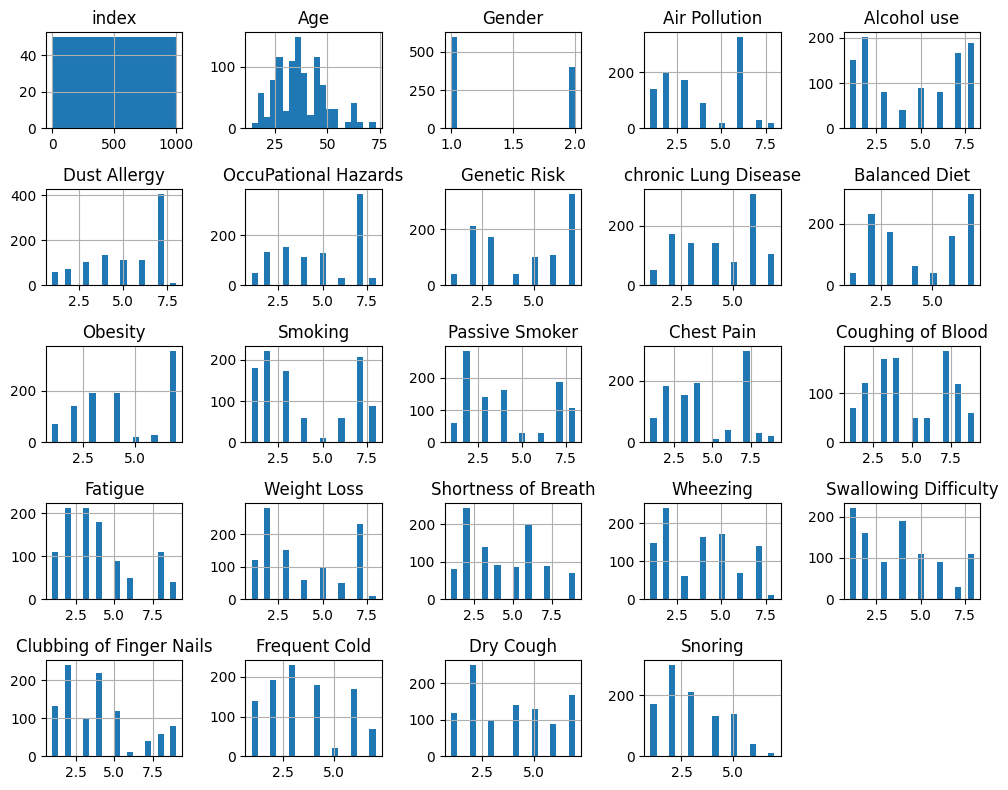

In [6]:
# Histograms of Numeric Columns
print("Histogram for Numeric Features:")
df[numerical_cols].hist(figsize=(10, 8), bins=20)
plt.tight_layout()
plt.show()

# Data Visualization
Visualize the distribution of numerical features and the target variable to gain insights into the data's characteristics.

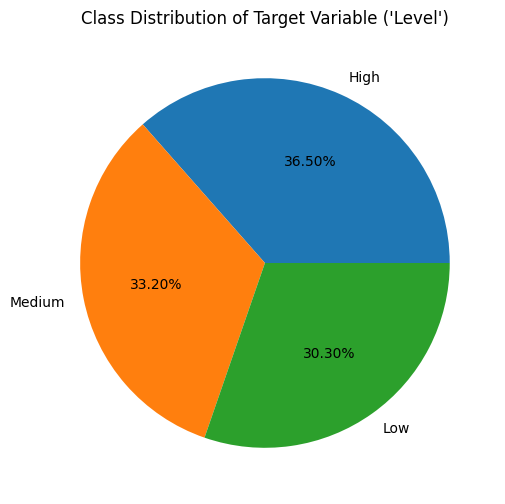



Unique values in 'Level' column (before label encoding):
['Low' 'Medium' 'High']

Class distribution for 'Level'
Level
High      365
Medium    332
Low       303
Name: count, dtype: int64


In [7]:
"""Data Visualization"""

# Target distribution visualization
target_dist = df['Level'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(target_dist, labels=target_dist.index, autopct='%.2f%%')
plt.title("Class Distribution of Target Variable ('Level')")
plt.show()

print("\n")
print("Unique values in 'Level' column (before label encoding):")
print(df['Level'].unique())

print("\nClass distribution for 'Level'")
print(df['Level'].value_counts())

The classes in of the target variable is distributed almost equally with no bias towards one particular class (balanced dataset), hence there is no need to oversample/undersample.

# Preprocessing Steps
The preprocessing steps performed on the lung cancer dataset are as follows:

* Data Cleaning:
Dropped irrelevant columns: index and Patient Id.

* Label Encoding:
Converted the target column Level (Low, Medium, High) into numerical labels using LabelEncoder.

* Feature Scaling:
Standardized all numerical features using StandardScaler to ensure consistent scaling for model training.

* Train-Test Split:
Split the data into training (80%) and testing (20%) sets for model evaluation.

In [8]:
# Drop unnecessary columns
df = df.drop(['index', 'Patient Id'], axis=1)

# Label encode the target
label_encoder = LabelEncoder()
df['Level'] = label_encoder.fit_transform(df['Level'])

# Split features and target
X = df.drop('Level', axis=1)
y = df['Level']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

Plotting Correlation Heatmap to identify potential relationships between variables.

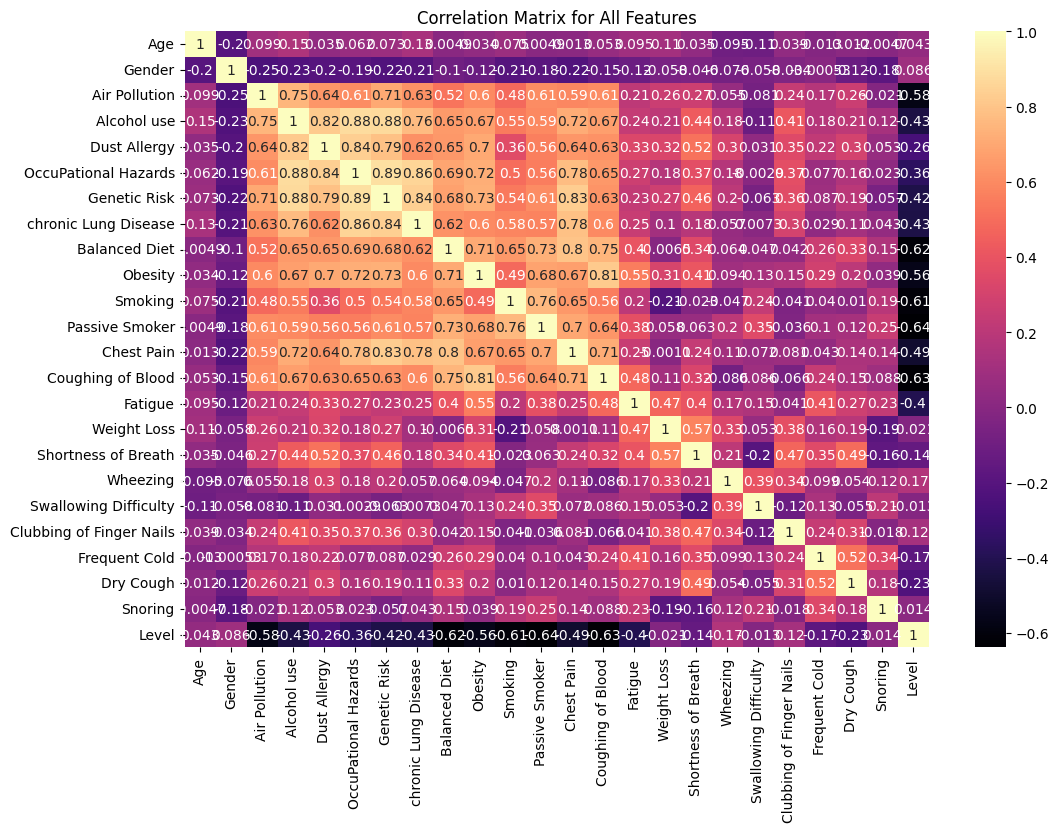

In [9]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='magma')
plt.title('Correlation Matrix for All Features')
plt.show()

# Baseline (Default) Models
Train and evaluate multiple baseline classification models using default hyperparameters. This provides a benchmark for comparing more advanced models and tuned versions.

In [10]:
print("Baseline (Default) Models\n")

baseline_models = {
    "XGBoost": XGBClassifier(
        use_label_encoder=False,
        eval_metric='mlogloss',
        random_state=42
    ),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(random_state=42),
    "Neural Network": MLPClassifier(random_state=42, max_iter=1000)
}

for model_name, model in baseline_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{model_name} (Baseline) - Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))
    print("-"*60)

Baseline (Default) Models

XGBoost (Baseline) - Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        82
           1       1.00      1.00      1.00        55
           2       1.00      1.00      1.00        63

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

------------------------------------------------------------
AdaBoost (Baseline) - Accuracy: 0.7250
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        82
           1       0.00      0.00      0.00        55
           2       0.53      1.00      0.70        63

    accuracy                           0.73       200
   macro avg       0.51      0.67      0.57       200
weighted avg       0.58      0.72      0.63       200

------------------------------------------------------------
Random Fores

# Confusion Matrix Visualization
Visualize the performance of each baseline model using confusion matrices. This helps in understanding the types of errors each model is making.

In [11]:
# Define confusion matrix plotting function
def plot_confusion_matrix(y_true, y_pred, model_name, label_encoder):
    """
    Plots a confusion matrix for a given model.
    Assumes 'label_encoder' is used to get class names from integer labels.
    """
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    import matplotlib.pyplot as plt

    conf_matrix = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    print("\n")

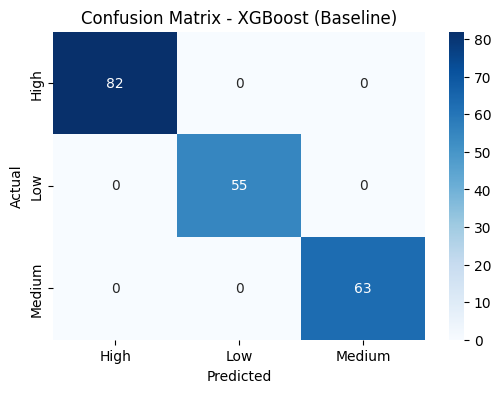

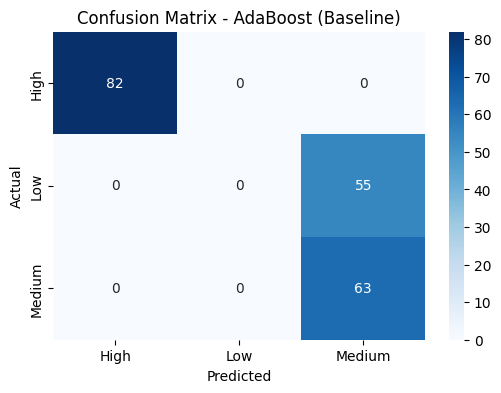

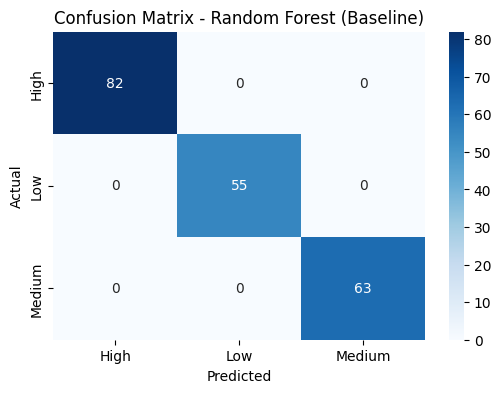

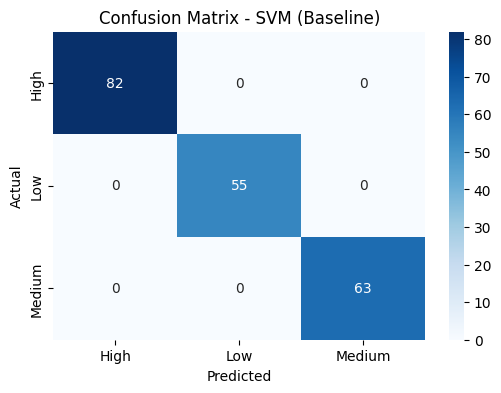

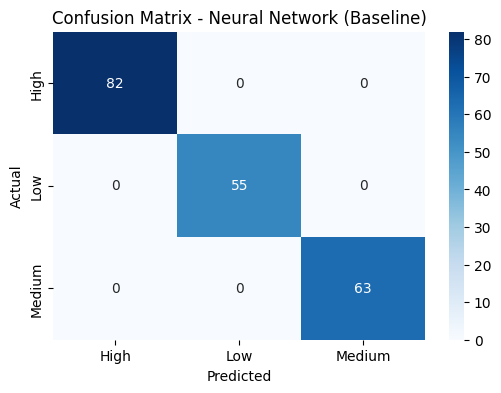

In [12]:
for model_name, model in baseline_models.items():
    y_pred = model.predict(X_test)
    plot_confusion_matrix(y_test, y_pred, model_name + " (Baseline)", label_encoder)

# Hyperparameter Tuning
Optimize the performance of each model by tuning their hyperparameters using RandomizedSearchCV. This step explores various combinations of parameters to find the best configuration for each classifier.

In [13]:
# XGBoost parameter
param_grid_xgb = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'gamma': [0, 0.1, 0.5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1, 2]
}

# AdaBoost parameter
param_grid_adaboost = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0],
    'base_estimator': [
        DecisionTreeClassifier(max_depth=1),
        DecisionTreeClassifier(max_depth=2),
        DecisionTreeClassifier(max_depth=3)
    ],
    'algorithm': ['SAMME', 'SAMME.R']
}

# Random Forest parameter
param_grid_rf = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False]
}

# SVM parameter
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

# Neural Network parameter
param_grid_nn = {
    'hidden_layer_sizes': [(50,), (100,), (50,50), (100,50)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant','adaptive']
}

# Model-Specific Hyperparameter Optimization
Apply RandomizedSearchCV to each model with the defined parameter grids to find the optimal hyperparameters. This process involves training multiple models with different configurations and selecting the best-performing ones based on cross-validation scores.

In [14]:
# 1. XGBoost Tuning
xgb_clf = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

random_search_xgb = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_grid_xgb,
    n_iter=20,               # number of parameter settings that are sampled
    scoring='accuracy',
    cv=5,                    # 5-fold cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1                # use all available cores
)

random_search_xgb.fit(X_train, y_train)

# Print best results for XGBoost
print("Best params for XGB:", random_search_xgb.best_params_)
print("Best CV score for XGB:", random_search_xgb.best_score_)

# 2. AdaBoost Tuning
ada_clf = AdaBoostClassifier(random_state=42)

random_search_ada = RandomizedSearchCV(
    estimator=ada_clf,
    param_distributions=param_grid_adaboost,
    n_iter=20,
    scoring='accuracy',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search_ada.fit(X_train, y_train)

# Print best results for AdaBoost
print("\nBest params for AdaBoost:", random_search_ada.best_params_)
print("Best CV score for AdaBoost:", random_search_ada.best_score_)

# 3. Random Forest Tuning
rf_clf = RandomForestClassifier(random_state=42)

random_search_rf = RandomizedSearchCV(
    estimator=rf_clf,
    param_distributions=param_grid_rf,
    n_iter=20,
    scoring='accuracy',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search_rf.fit(X_train, y_train)

# Print best results for Random Forest
print("\nBest params for RF:", random_search_rf.best_params_)
print("Best CV score for RF:", random_search_rf.best_score_)

# 4. SVM Tuning
svm_clf = SVC(random_state=42)

random_search_svm = RandomizedSearchCV(
    estimator=svm_clf,
    param_distributions=param_grid_svm,
    n_iter=20,
    scoring='accuracy',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)
random_search_svm.fit(X_train, y_train)

# Print best results for SVM
print("\nBest params for SVM:", random_search_svm.best_params_)
print("Best CV score for SVM:", random_search_svm.best_score_)

# 5. Neural Network (MLP) Tuning
nn_clf = MLPClassifier(random_state=42, max_iter=1000)

random_search_nn = RandomizedSearchCV(
    estimator=nn_clf,
    param_distributions=param_grid_nn,
    n_iter=20,
    scoring='accuracy',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)
random_search_nn.fit(X_train, y_train)

# Print best results for Neural Network
print("\nBest params for Neural Network:", random_search_nn.best_params_)
print("Best CV score for Neural Network:", random_search_nn.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best params for XGB: {'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 0.1, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.2, 'gamma': 0.5, 'colsample_bytree': 0.8}
Best CV score for XGB: 1.0
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best params for AdaBoost: {'n_estimators': 100, 'learning_rate': 0.1, 'base_estimator': DecisionTreeClassifier(max_depth=3), 'algorithm': 'SAMME.R'}
Best CV score for AdaBoost: 1.0
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best params for RF: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 15, 'criterion': 'gini', 'bootstrap': True}
Best CV score for RF: 1.0
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best params for SVM: {'kernel': 'rbf', 'gamma': 'auto', 'C': 100}
Best CV score for SVM: 1.0
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best params for 

# Evaluating Tuned Models
Retrieve the best estimators from the hyperparameter tuning process and evaluate their performance on the test set. This step compares the optimized models against the baseline models.

In [15]:
best_xgb = random_search_xgb.best_estimator_
best_ada = random_search_ada.best_estimator_
best_rf  = random_search_rf.best_estimator_
best_svm = random_search_svm.best_estimator_
best_nn  = random_search_nn.best_estimator_

# Evaluate on the test set
models = {
    "XGBoost": best_xgb,
    "AdaBoost": best_ada,
    "Random Forest": best_rf,
    "SVM": best_svm,
    "Neural Network": best_nn
}

for model_name, model in models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n=== {model_name} ===")
    print("Accuracy:", acc)
    print(classification_report(y_test, y_pred))


=== XGBoost ===
Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        82
           1       1.00      1.00      1.00        55
           2       1.00      1.00      1.00        63

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200


=== AdaBoost ===
Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        82
           1       1.00      1.00      1.00        55
           2       1.00      1.00      1.00        63

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200


=== Random Forest ===
Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        82
           1       1.00      

# Confusion Matrix for Tuned Models
Visualize the confusion matrices for the fine-tuned models to assess their classification performance in detail.

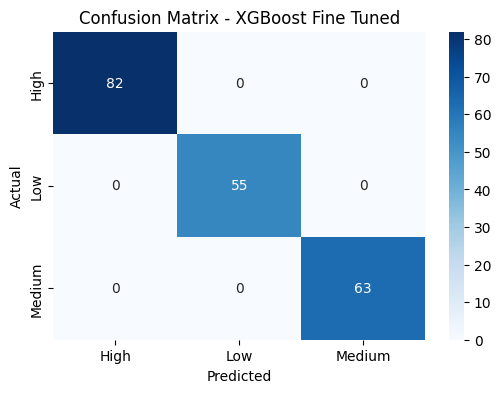

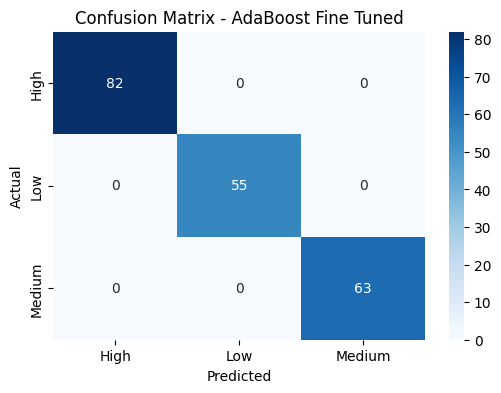

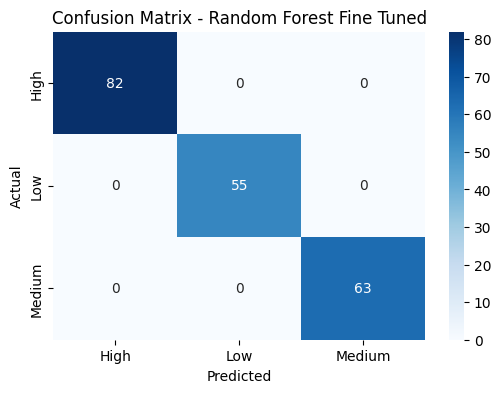

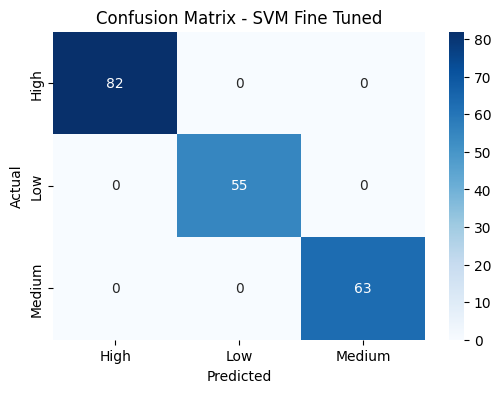

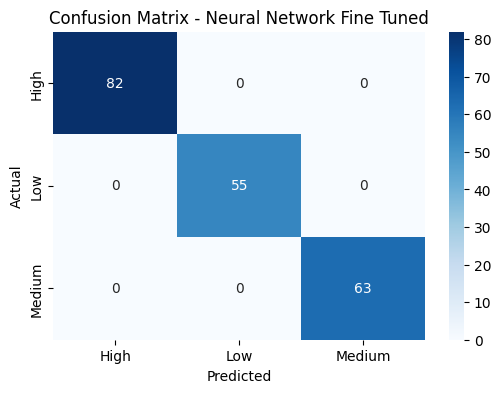

In [16]:
for model_name, model in models.items():
    y_pred = model.predict(X_test)
    plot_confusion_matrix(y_test, y_pred, model_name+" Fine Tuned", label_encoder)
    print("\n")

# Testing Specific Row Classifications
Evaluate how each model classifies specific instances in the dataset. This can help in understanding model behavior on individual data points.

In [17]:
def test_row_classification(models, row_index, X, y, scaler=None, label_encoder=None):
    """
    Test the classification of a specific row by multiple models.
    Args:
    - models: Dictionary of models to test.
    - row_index: Index of the row to test.
    - X: Original feature DataFrame.
    - y: Target series.
    - scaler: Scaler used for preprocessing (if any).
    - label_encoder: Label encoder for the target variable (if any).
    """
    # Extract the specific row and its true label
    row = X.iloc[[row_index]]  # double brackets to keep it as DataFrame
    true_label = y.iloc[row_index]

    if scaler:
        row = scaler.transform(row)

    print(f"\nTesting row {row_index}:")
    print(f"True label: {true_label} "
          f"({label_encoder.inverse_transform([true_label])[0] if label_encoder else true_label})")

    # Test the row with each model
    for model_name, model in models.items():
        prediction = model.predict(row)[0]
        decoded_pred = label_encoder.inverse_transform([int(prediction)])[0] if label_encoder else prediction
        print(f"{model_name} Prediction: {int(prediction)} ({decoded_pred})")
    print("\n-------------------------------")

# Convert X back to DataFrame for testing a specific row
X_df = pd.DataFrame(X_scaled, columns=X.columns)

random_indices = random.sample(range(len(X_df)), 5)
for row_index in random_indices:
    test_row_classification(models, row_index, X_df, y, scaler=None, label_encoder=label_encoder)


Testing row 209:
True label: 0 (High)
XGBoost Prediction: 0 (High)
AdaBoost Prediction: 0 (High)
Random Forest Prediction: 0 (High)
SVM Prediction: 0 (High)
Neural Network Prediction: 0 (High)

-------------------------------

Testing row 925:
True label: 1 (Low)
XGBoost Prediction: 1 (Low)
AdaBoost Prediction: 1 (Low)
Random Forest Prediction: 1 (Low)
SVM Prediction: 1 (Low)
Neural Network Prediction: 1 (Low)

-------------------------------

Testing row 130:
True label: 2 (Medium)
XGBoost Prediction: 2 (Medium)
AdaBoost Prediction: 2 (Medium)
Random Forest Prediction: 2 (Medium)
SVM Prediction: 2 (Medium)
Neural Network Prediction: 2 (Medium)

-------------------------------

Testing row 490:
True label: 2 (Medium)
XGBoost Prediction: 2 (Medium)
AdaBoost Prediction: 2 (Medium)
Random Forest Prediction: 2 (Medium)
SVM Prediction: 2 (Medium)
Neural Network Prediction: 2 (Medium)

-------------------------------

Testing row 264:
True label: 1 (Low)
XGBoost Prediction: 1 (Low)
AdaBoost

# Tree visualizations
For XGBoost, AdaBoost, and Random Forest highlight feature splits and decision-making processes within each model, providing insights into feature importance and how predictions are structured across different ensemble methods.

XGBoost Tree


<Figure size 1600x1000 with 0 Axes>

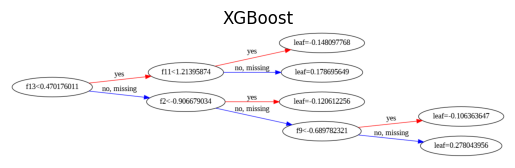

In [18]:
# 1. XGBoost Visualization
print("XGBoost Tree")
plt.figure(figsize=(16, 10))
xgb.plot_tree(best_xgb, num_trees=0, rankdir='LR')
plt.title("XGBoost")
plt.show()

AdaBoost Tree


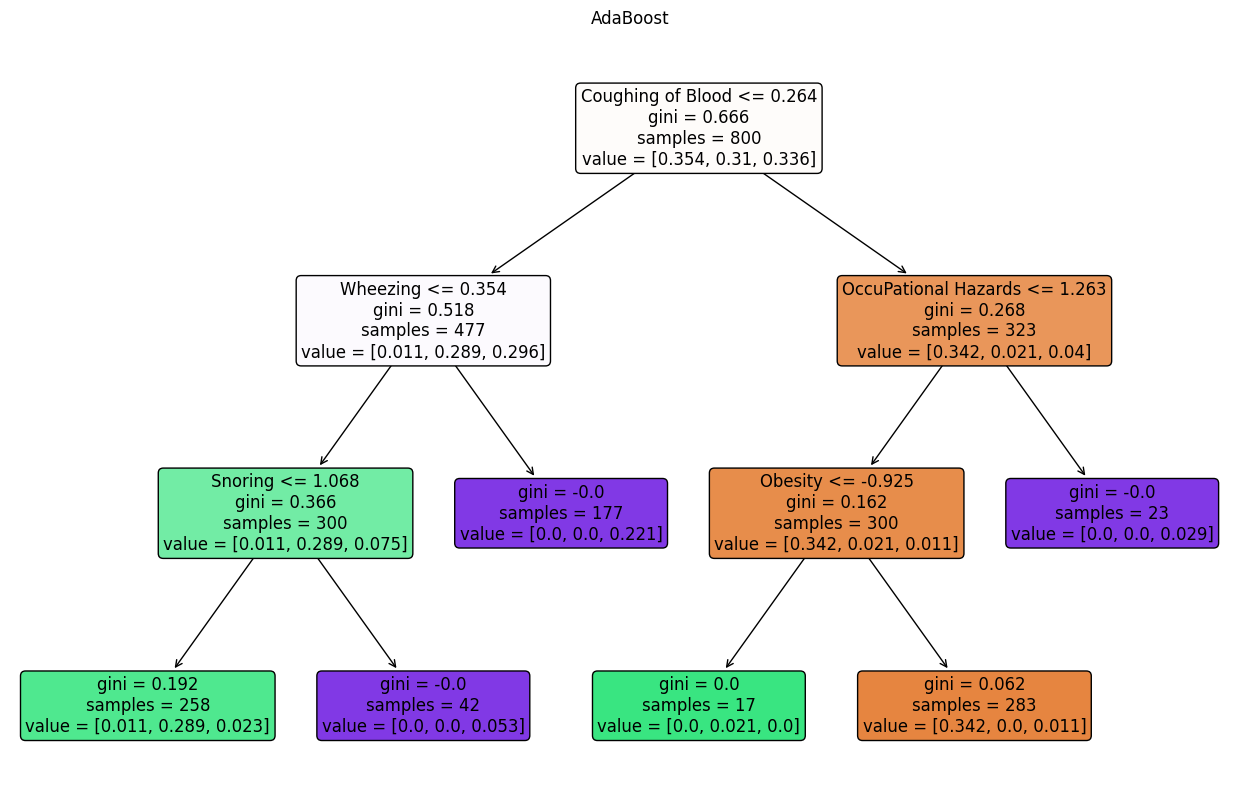

In [20]:
# 2. AdaBoost Visualization
print("AdaBoost Tree")
base_estimator = best_ada.estimators_[0]
plt.figure(figsize=(16, 10))
plot_tree(base_estimator, filled=True, rounded=True, feature_names=X.columns)
plt.title("AdaBoost")
plt.show()

Random Forest Tree


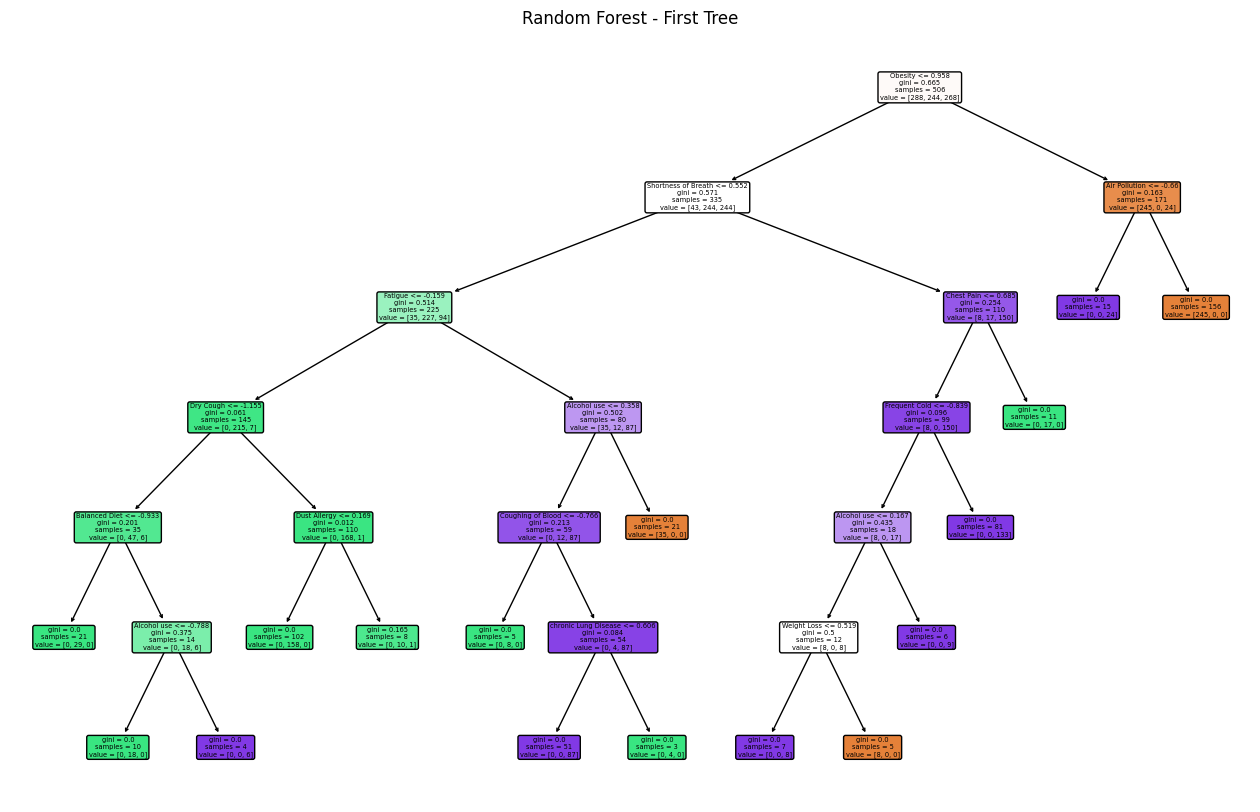

In [67]:
# 3. Random Forest Visualization
print("Random Forest Tree")
rf_tree = best_rf.estimators_[0]
plt.figure(figsize=(16, 10))
plot_tree(rf_tree, filled=True, rounded=True, feature_names=X.columns)
plt.title("Random Forest")
plt.show()

# Feature Importance Visualization
Identify and visualize the most influential features for tree-based models. Understanding feature importance helps in interpreting the models and identifying key factors contributing to lung cancer risk.

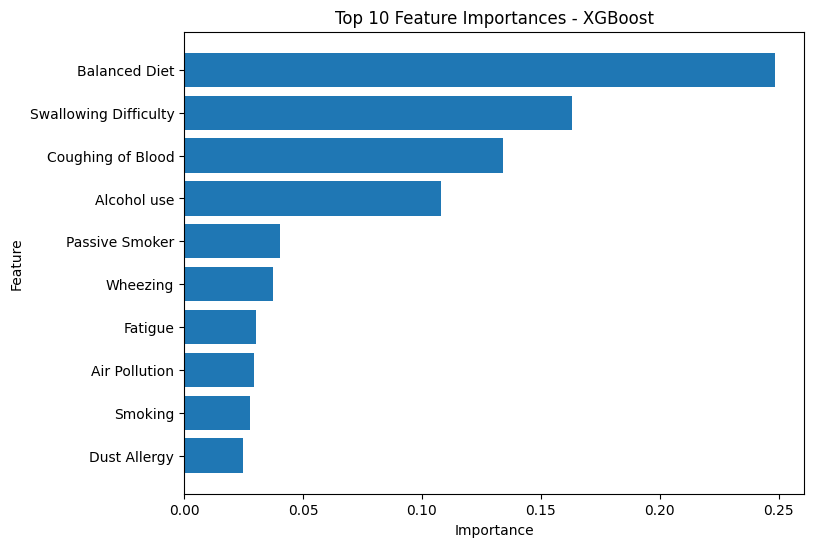

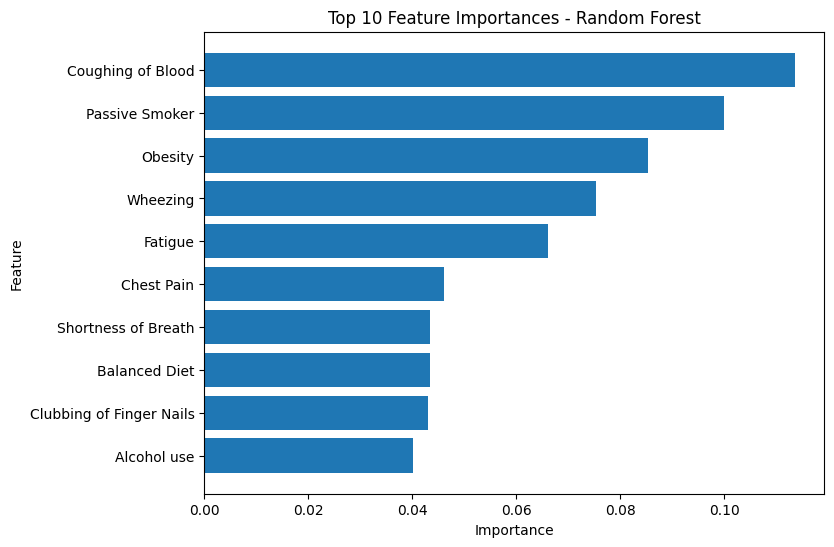

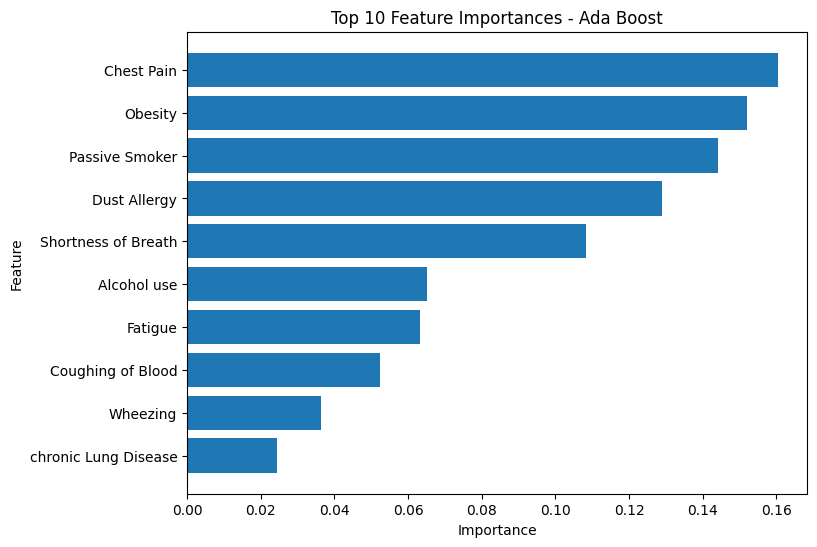

In [23]:
import numpy as np
import matplotlib.pyplot as plt

def plot_feature_importances(model, feature_names, top_n=10, model_name="Model"):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[-top_n:]
        plt.figure(figsize=(8, 6))
        plt.barh(np.array(feature_names)[indices], importances[indices])
        plt.title(f"Top {top_n} Feature Importances - {model_name}")
        plt.xlabel("Importance")
        plt.ylabel("Feature")
        plt.show()
    else:
        print(f"{model_name} does not have 'feature_importances_' attribute.")

plot_feature_importances(best_xgb, X.columns, top_n=10, model_name="XGBoost")
print("\n")
plot_feature_importances(best_rf, X.columns, top_n=10, model_name="Random Forest")
print("\n")
plot_feature_importances(best_ada, X.columns, top_n=10, model_name="Ada Boost")

# Learning Curves
Plot learning curves to evaluate how each model's performance changes with varying training set sizes. This helps in assessing whether models are overfitting or underfitting.

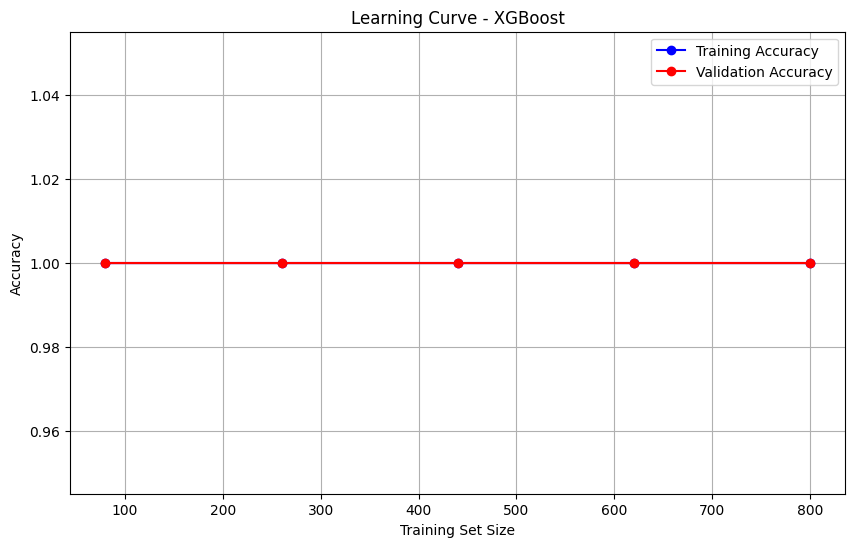

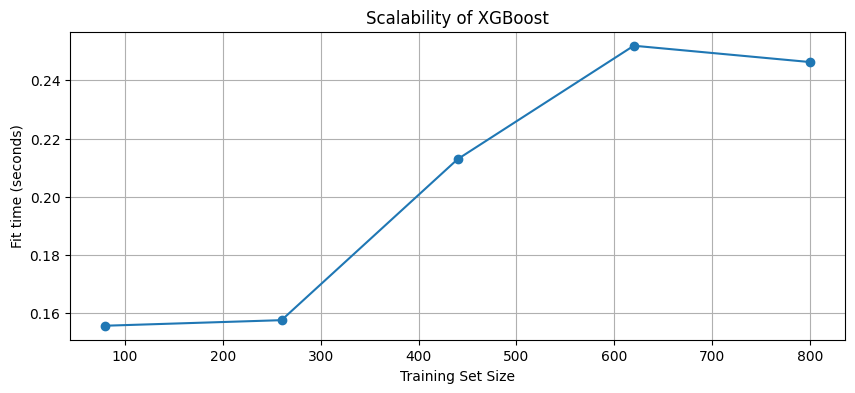

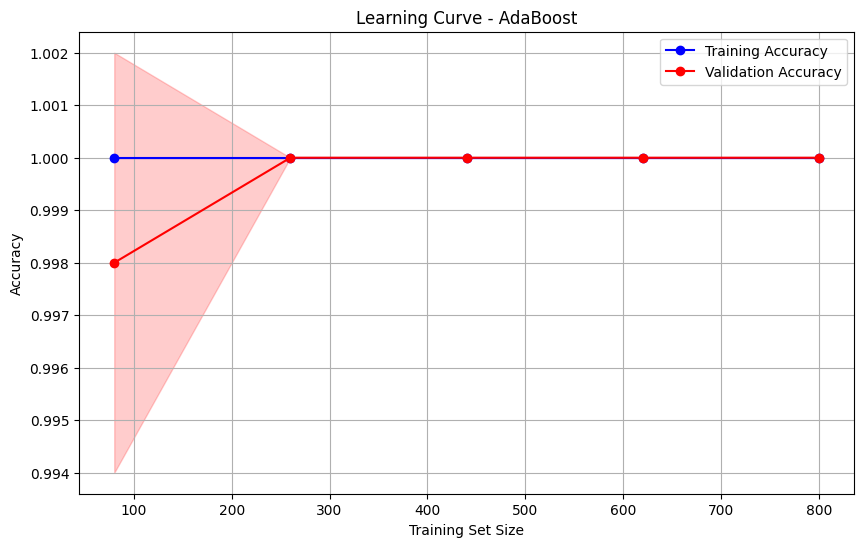

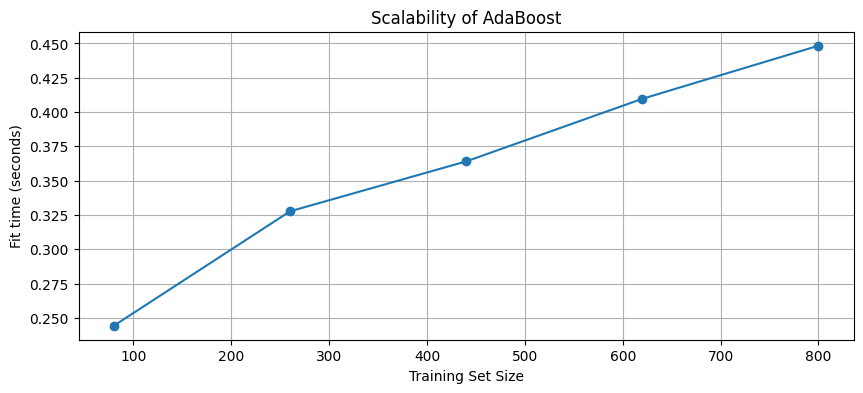

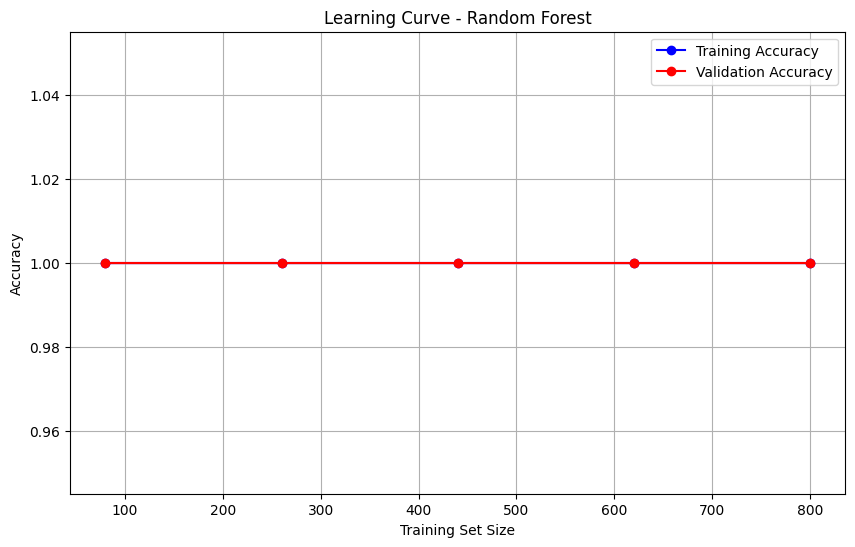

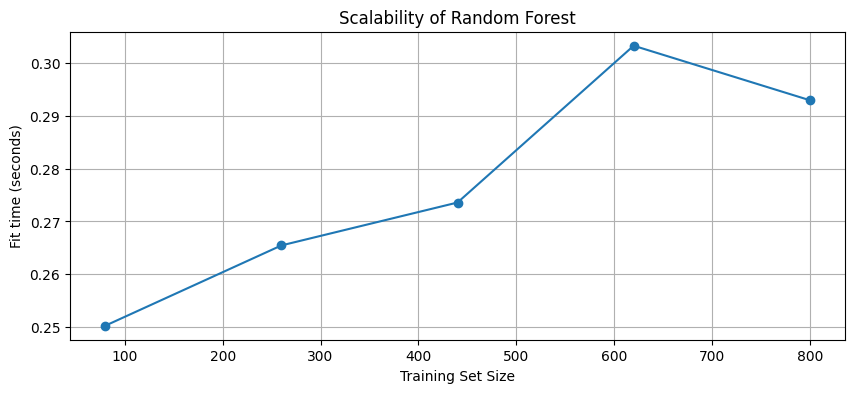

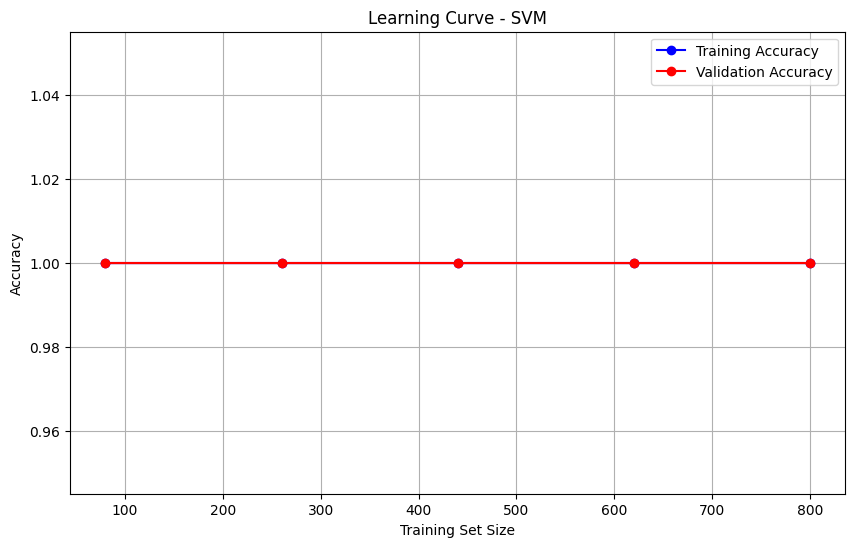

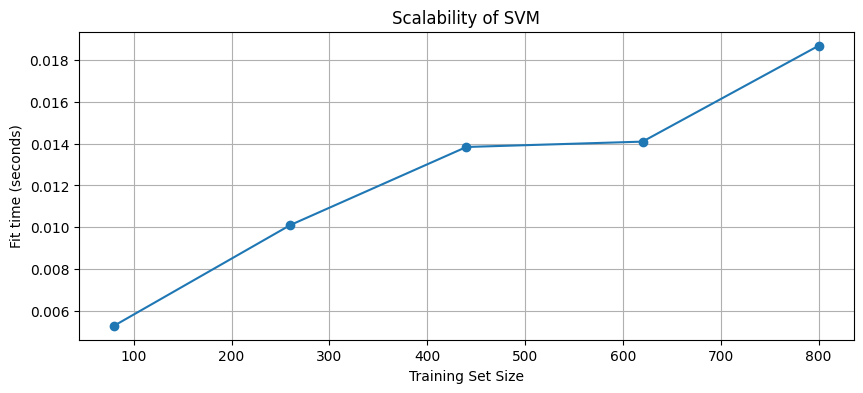

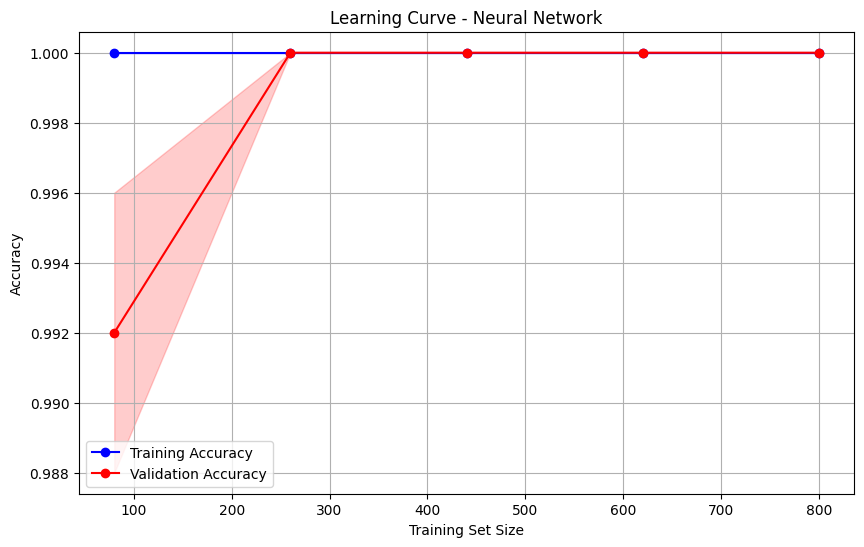

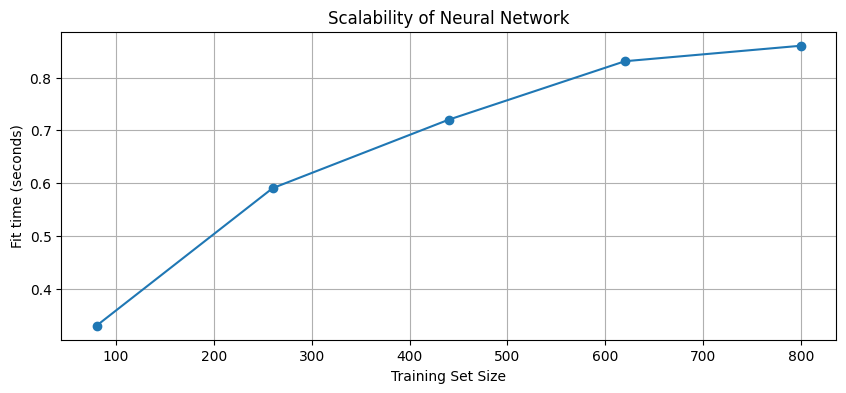

In [21]:
def plot_learning_curves(estimator, X, y, cv=5, scoring='accuracy', model_name='Model'):
    """
    Plots the training and validation (cross-validation) accuracy
    as a function of the training set size.
    """
    train_sizes, train_scores, val_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        return_times=True,
        train_sizes=np.linspace(0.1, 1.0, 5)
    )

    # Calculate mean and std for train and validation scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std  = np.std(train_scores, axis=1)
    val_scores_mean   = np.mean(val_scores, axis=1)
    val_scores_std    = np.std(val_scores, axis=1)
    fit_times_mean    = np.mean(fit_times, axis=1)

    # Plot learning curves
    plt.figure(figsize=(10, 6))
    plt.title(f"Learning Curve - {model_name}")
    plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training Accuracy')
    plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.2, color='blue'
    )
    plt.plot(train_sizes, val_scores_mean, 'o-', color='red', label='Validation Accuracy')
    plt.fill_between(
        train_sizes,
        val_scores_mean - val_scores_std,
        val_scores_mean + val_scores_std,
        alpha=0.2, color='red'
    )
    plt.xlabel("Training Set Size")
    plt.ylabel("Accuracy")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.plot(train_sizes, fit_times_mean, 'o-')
    plt.title(f"Scalability of {model_name}")
    plt.xlabel("Training Set Size")
    plt.ylabel("Fit time (seconds)")
    plt.grid(True)
    plt.show()

# Use scaled data and original labels for learning curves
X_full = X_scaled
y_full = y

# Plot for each best model
plot_learning_curves(best_xgb, X_full, y_full, cv=5, scoring='accuracy', model_name='XGBoost')
print("\n")
plot_learning_curves(best_ada, X_full, y_full, cv=5, scoring='accuracy', model_name='AdaBoost')
print("\n")
plot_learning_curves(best_rf, X_full, y_full, cv=5, scoring='accuracy', model_name='Random Forest')
print("\n")
plot_learning_curves(best_svm, X_full, y_full, cv=5, scoring='accuracy', model_name='SVM')
print("\n")
plot_learning_curves(best_nn, X_full, y_full, cv=5, scoring='accuracy', model_name='Neural Network')

# Evaluating Model Efficiency
Measure the training and inference times of each model to assess their computational efficiency. This is crucial for understanding the practicality of deploying the models in real-world scenarios.

In [22]:
def evaluate_efficiency(models, X_train, y_train, X_test):
    """
    Times how long each model takes to train and to predict on the test set.
    Returns dicts of training_times and inference_times.
    """
    training_times = {}
    inference_times = {}

    print("Efficiency (Timing)")

    for model_name, model in models.items():
        # Clone/instantiate a fresh version if needed; or re-fit the best estimator directly
        # For demonstration, we assume you just re-fit best_* as is.

        start_time = time.time()
        model.fit(X_train, y_train)
        training_times[model_name] = time.time() - start_time

        start_time = time.time()
        _ = model.predict(X_test)
        inference_times[model_name] = time.time() - start_time

        print(f"{model_name}: Training Time = {training_times[model_name]:.4f}s, "
              f"Inference Time = {inference_times[model_name]:.4f}s")

    print()
    return training_times, inference_times

# Example usage
training_times, inference_times = evaluate_efficiency(models, X_train, y_train, X_test)

Efficiency (Timing)
XGBoost: Training Time = 0.1270s, Inference Time = 0.0023s
AdaBoost: Training Time = 0.2927s, Inference Time = 0.0183s
Random Forest: Training Time = 0.1759s, Inference Time = 0.0095s
SVM: Training Time = 0.0095s, Inference Time = 0.0018s
Neural Network: Training Time = 0.6315s, Inference Time = 0.0008s

